## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
sys.path.append('hifigan/')
import numpy as np
import torch
import librosa
import librosa.display
import math
import json
import os

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence, symbol_to_id
from text.cleaners import transliteration_ua_cleaners, english_cleaners, transliteration_cleaners,transliteration_cleaners_with_stress
from text.rudict import RuDict

from torch.nn import functional as F

from sklearn.metrics.pairwise import cosine_similarity as cs


from hifigan.meldataset import MAX_WAV_VALUE
from hifigan.models import Generator
from hifigan.env import AttrDict

from audio_processing import get_mel

loaded = False



In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.savefig('out.png')
    ipd.display(ipd.Image('out.png'))

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.end_symbols_ids = [symbol_to_id[s] for s in '?!.']
# hparams.use_gst = False

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
checkpoint_path = "checkpoint_46500"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [19]:
ref_mel = get_mel('test/test3.wav', hparams).type(torch.HalfTensor).cuda()
print(ref_mel.dtype, ref_mel.shape)

torch.float16 torch.Size([1, 80, 494])


In [6]:
print(ref_mel)

tensor([[[-3.2363, -2.8613, -2.9082,  ..., -2.1523, -2.1094, -2.0898],
         [-4.6133, -4.9492, -5.1523,  ..., -4.4961, -4.4922, -4.4805],
         [-7.0156, -6.4062, -6.4336,  ..., -6.4727, -6.5977, -7.1055],
         ...,
         [-9.5312, -9.2891, -9.2969,  ..., -9.3516, -9.2422, -9.4922],
         [-9.4922, -9.6328, -9.5547,  ..., -9.7109, -9.5312, -9.4297],
         [-9.6328, -9.5938, -9.2422,  ..., -9.6406, -9.6172, -9.5938]]],
       device='cuda:0', dtype=torch.float16)


In [7]:

text = "Тетрагидропиранилциклопентилтетрагидропиридопиридиновые вещества".lower()
# text = "Мин+истр здравоохран+ения улет+ел. И обещ+ал верн+уться. С вакц+инами. Нав+ерно, +есть как+ой-то м+ир, где мин+истрам л+ично н+адо лет+ать за вакц+инами с четырьм+я перес+адками во вр+емя эпид+емии. М+ожет по+этому в Зимб+абве уже вакцин+ируют, потом+у чт+о их мин+истр л+ично с+ел на слон+а и по+ехал на нем в больш+ой г+ород преклон+ить кол+ено и получ+ить вакц+ину? Так+ой м+ир нам пыт+аются прод+ать?".lower()
# text = "Вс+е смеш+алось в д+оме Обл+онских. Жен+а узн+ала, что муж был в св+язи с б+ывшею в их д+оме франц+уженкою-гуверн+анткой, и объяв+ила м+ужу, что не м+ожет ж+ить с ним в одн+ом д+оме. Полож+ение это продолж+алось уже третий д+ень и муч+ительно ч+увствовалось и сам+ими супр+угами, и вс+еми чл+енами семь+и, и домоч+адцами."
text = "Тв+орог или твор+ог, к+озлы или козл+ы, з+амок или зам+ок.".lower()
# text="мн+е хот+елось б+ы? сказ+ать к+ак я призн+ателен вс+ем прис+утсвующим сд+есь."
# text = "tak+oi m+ir n+am pyt+aiutsia prod+at'?"
# text = "Как пройти в дом."
# text = "В+ыйду,,,,,,, н+очью,,, в п+оле,,, с кон+ем"
text = "Н+очь, +улица, фон+арь, апт+ека. Бессм+ысленный, и т+усклый св+ет. Жив+и ещ+е х+оть ч+етверть в+ека - Вс+ё б+удет т+ак. Исх+ода н+ет."
# text = "Ночь, улица, фонарь, аптека. Бессмысленный, и тусклый свет. Жив+и еще хоть четверть века - Все будет так. Исхода нет."
# text = "Игра - тип осмысленной непродуктивной деятельности, где мотив лежит не в её результате, а в самом процессе. Также термин игра используют для обозначения набора предметов или программ, предназначенных для подобной деятельности."
# text = "Прижм+ись к+о мн+е кр+епче и бл+иже. Не ж+ил я, блужд+ал ср+едь чуж+их. О, с+он м+ой, Я н+овое в+ижу, В бред+у поцел+уев тво+их!"

# text = "Тогд+а почем+у ж+е я ощущ+аю себ+я н+а гр+ани физ+ической катастр+офы?"

print(transliteration_cleaners_with_stress(text))
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners_with_stress']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

Sn+och', +ulitsa, fon+ar', apt+eka. bessm+yslennyi, i t+usklyi sv+et. zhiv+i eshch+e kh+ot' ch+etvert' v+eka - vs+io b+udet t+ak. iskh+oda n+et.E
[[12 27 40 28 16 21  3  6 11 40 34 25 22 33 32 14  6 11 19 28 27 40 14 31
   3  6 11 14 29 33 40 18 24 14  7 11 15 18 32 32 26 40 38 32 25 18 27 27
  38 22  6 11 22 11 33 40 34 32 24 25 38 22 11 32 35 40 18 33  7 11 39 21
  22 35 40 22 11 18 32 21 16 21 40 18 11 24 21 40 28 33  3 11 16 21 40 18
  33 35 18 31 33  3 11 35 40 18 24 14 11  1 11 35 32 40 22 28 11 15 40 34
  17 18 33 11 33 40 14 24  7 11 22 32 24 21 40 28 17 14 11 27 40 18 33  7
  13]]


In [36]:
%%time
# np.random.seed(16)

_, mel_outputs, mel_outputs_postnet, _, alignments, emb2 = model.inference(sequence,seed=None, scale=0.0,reference_mel=ref_mel)

tensor([[[[0.0478, 0.1085, 0.0858, 0.0733, 0.1176, 0.0294, 0.0792, 0.0861,
           0.2683, 0.1040]]],


        [[[0.1267, 0.0794, 0.0997, 0.0803, 0.1096, 0.0776, 0.1262, 0.0858,
           0.1086, 0.1058]]],


        [[[0.0497, 0.1124, 0.0887, 0.0720, 0.1166, 0.1207, 0.0864, 0.1448,
           0.1080, 0.1009]]],


        [[[0.0317, 0.0253, 0.1229, 0.0226, 0.1224, 0.1028, 0.0732, 0.3394,
           0.1198, 0.0400]]],


        [[[0.0405, 0.0725, 0.3486, 0.0404, 0.0815, 0.0948, 0.1058, 0.0473,
           0.1166, 0.0520]]],


        [[[0.0485, 0.0505, 0.0412, 0.0031, 0.1768, 0.0037, 0.2017, 0.4133,
           0.0485, 0.0130]]],


        [[[0.0870, 0.0945, 0.0986, 0.0866, 0.1188, 0.0761, 0.1237, 0.1111,
           0.0856, 0.1180]]],


        [[[0.0573, 0.0742, 0.0094, 0.0226, 0.0895, 0.0522, 0.0519, 0.0891,
           0.2991, 0.2549]]]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SoftmaxBackward>)
tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)

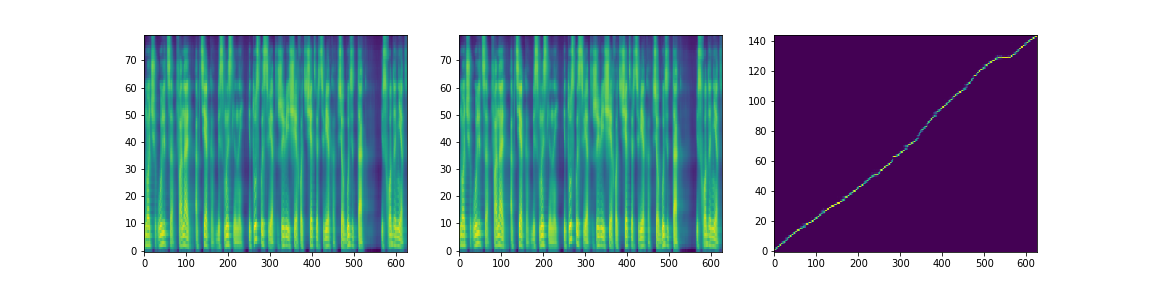

In [37]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [38]:
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

if not loaded:
    device = torch.device('cuda')
    with open('hifigan/config.json') as fp:
        json_config = json.load(fp)
        h = AttrDict(json_config)
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint("hifigan/g_02500000", device)
    generator.load_state_dict(state_dict_g['generator'])
    generator.eval()
    generator.remove_weight_norm()
    loaded=True

def inference(mel, generator):
    

    
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    


In [39]:
%%time
mel = mel_outputs_postnet.type(torch.float32)

audio = inference(mel, generator)
ipd.Audio(audio, rate=hparams.sampling_rate)              

CPU times: user 343 ms, sys: 487 µs, total: 344 ms
Wall time: 343 ms


In [22]:
# style vectors similarity
vect = model.gst.stl.embed

In [23]:
norm = F.normalize(vect, dim=1).detach().cpu().numpy()
res =  cs(norm, norm)
res

array([[ 1.        , -0.29705411, -0.16876671, -0.05282461, -0.09659034,
         0.0168579 , -0.04595524, -0.19878264, -0.08360261, -0.08049491],
       [-0.29705411,  1.        , -0.0103188 ,  0.00761308, -0.02571157,
        -0.17190242, -0.13340296,  0.02273257, -0.26846636, -0.03690357],
       [-0.16876671, -0.0103188 ,  1.        ,  0.03464246, -0.12897791,
        -0.07475086,  0.02186553, -0.13300402, -0.15130561, -0.25332638],
       [-0.05282461,  0.00761308,  0.03464246,  1.        , -0.12874766,
        -0.05228307, -0.21140563, -0.27634512, -0.18369156, -0.04429065],
       [-0.09659034, -0.02571157, -0.12897791, -0.12874766,  1.        ,
        -0.22029289, -0.24503299, -0.03547729, -0.04590818, -0.02265081],
       [ 0.0168579 , -0.17190242, -0.07475086, -0.05228307, -0.22029289,
         1.        , -0.15246721,  0.00609751, -0.04875763, -0.28772697],
       [-0.04595524, -0.13340296,  0.02186553, -0.21140563, -0.24503299,
        -0.15246721,  1.        , -0.05684062

In [21]:
(emb1.detach().cpu().numpy()[0][0] - emb2.detach().cpu().numpy()[0][0])

array([-1.6155e-03, -6.5002e-03,  2.1782e-03, -6.2714e-03, -5.3444e-03,
        2.7695e-03, -3.9673e-03,  1.5106e-02,  9.8038e-04, -2.9697e-03,
       -9.1095e-03,  1.0750e-02, -5.8365e-03, -1.1162e-02,  8.0490e-04,
        3.0975e-03, -1.6953e-02, -9.9023e-01,  6.2408e-03,  6.5079e-03,
       -4.8065e-03,  3.0861e-03, -1.6928e-03, -7.1564e-03,  5.7031e-01,
       -2.4490e-03,  1.6479e-02, -1.1230e-02,  6.8550e-03,  7.6752e-03,
       -6.4278e-03, -7.8583e-03, -3.8770e-01, -8.1110e-04,  2.4438e-01,
       -2.1629e-03,  1.5736e-03,  1.5259e-05,  3.9520e-03,  8.3847e-03,
       -6.6223e-03, -3.7689e-03,  2.7924e-03,  1.8188e-02,  1.0033e-03,
        7.6294e-05,  2.2736e-03,  1.5049e-03, -3.5524e-04, -2.9240e-03,
       -3.5191e-03, -2.5711e-03, -2.9831e-03,  8.2970e-04, -3.2959e-02,
       -1.1787e-03,  2.7447e-03, -1.9131e-03,  4.5471e-03, -2.1881e-02,
       -3.2666e-01, -7.4959e-04, -1.1620e-02,  5.5618e-03, -6.8665e-05,
       -8.6975e-04,  1.2939e-01,  2.1019e-03, -3.5477e-04,  7.78

In [ ]:
print(emb1.detach().cpu().numpy().shape)